In [1]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))

import cv2
import torch
import pickle
import numpy as np
from utils.sim_utils import *
from utils.eval_utils import *
from utils.experiments_utils import *
import matplotlib.pyplot as plt
from utils.train_utils import *
from utils.sim_utils import *
from utils.couzin_utils import *
from models.Generator import ModularPolicy
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

c:\Users\janni\anaconda3\envs\GAIL\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[KeOps] Warning : No C++ compiler found. Define CXX environment variable or install g++.
[KeOps] Warning : No C++ compiler found. You need to either define the CXX environment variable pointing to a valid compiler, or ensure that 'g++' is installed and in your PATH.
[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.
[KeOps] Warning : No C++ compiler found. You need to either define the CXX environment variable pointing to a valid compiler, or ensure that 'g++' is installed and in your PATH.
[KeOps] Warning : No C++ compiler available to check for OpenMP support.
[KeOps] Warning : OpenMP support is not available. Disabling OpenMP.


## Model Comparison using Swarm Metrics

In [2]:
# GAIL Simulation

# load GAIL policies
gail_path = rf"..\results\Video pred-prey policy"
gail_prey_policy = ModularPolicy(features=5).to("cpu")
gail_prey_policy.load_state_dict(torch.load((os.path.join(gail_path, "prey_policy.pth")), map_location="cpu"))

gail_pred_policy = ModularPolicy(features=4).to("cpu")
gail_pred_policy.load_state_dict(torch.load((os.path.join(gail_path, "pred_policy.pth")), map_location="cpu"))

# run simulation with GAIL policies to get evaluation metrics
_, _, gail_metrics = run_env_simulation(visualization='off', 
                                        prey_policy=gail_prey_policy, 
                                        pred_policy=gail_pred_policy,
                                        n_prey=32, n_pred=1, 
                                        max_steps=200,
                                        pred_speed=10, prey_speed=10,
                                        area_width=2160, area_height=2160,
                                        max_turn = 0.314,
                                        step_size=1.0)

In [3]:
# BC Simulation

# load BC policies
bc_path = rf"..\models\trained_policies\BC-Policy"
bc_prey_policy = ModularPolicy(features=5).to("cpu")
bc_prey_policy.load_state_dict(torch.load((os.path.join(bc_path, "bc_prey_policy.pt")), map_location="cpu"))

bc_pred_policy = ModularPolicy(features=4).to("cpu")
bc_pred_policy.load_state_dict(torch.load((os.path.join(bc_path, "bc_pred_policy.pt")), map_location="cpu"))

# run simulation with BC policies to get evaluation metrics
_, _, bc_metrics = run_env_simulation(visualization='off', 
                                    prey_policy=bc_prey_policy, 
                                    pred_policy=bc_pred_policy,
                                    n_prey=32, n_pred=1, 
                                    max_steps=200,
                                    pred_speed=10, prey_speed=10,
                                    area_width=2160, area_height=2160,
                                    max_turn = 0.314,
                                    step_size=1.0)

In [4]:
# Couzin Simulation

# run Couzin simulation to get evaluation metrics
_, _, couzin_metrics, _, _ = run_couzin_simulation(visualization="off", max_steps=200, 
                                                constant_speed=10, shark_speed=10, 
                                                area_width=2160, area_height=2160,
                                                dt = 1.0, # step_size
                                                alpha=0.01, # social behavior - attack only
                                                theta_dot_max=0.56, theta_dot_max_shark=0.56,
                                                number_of_sharks=1, n=32)

In [5]:
# Random Policy Simulation

# create random policies
random_prey_policy = ModularPolicy(features=5).to("cpu")
random_prey_policy.set_parameters()

random_pred_policy = ModularPolicy(features=4).to("cpu")
random_pred_policy.set_parameters()

# run simulation with random policies to get evaluation metrics
_, _, random_metrics = run_env_simulation(visualization='off', 
                                        prey_policy=random_prey_policy, 
                                        pred_policy=random_pred_policy,
                                        n_prey=32, n_pred=1, 
                                        max_steps=200,
                                        pred_speed=10, prey_speed=10,
                                        area_width=2160, area_height=2160,
                                        max_turn = 0.314,
                                        step_size=1.0)

In [6]:
# load expert data
expert_path = rf'..\data\1. Data Processing\processed\video\expert_tensors\yolo_detected\expert_metrics_yd.pkl'
with open(expert_path, "rb") as f:
    expert_data = pickle.load(f)
expert_metrics = compute_expert_metrics(expert_data, 33)
print("Expert Metrics computed!")

# load init pool
init_pool_path = rf"..\data\1. Data Processing\processed\init_pool\init_pool.pt"
init_pool = torch.load(init_pool_path).to(device)
print("Init Pool Shape:", init_pool.shape)

Expert Metrics computed!
Init Pool Shape: torch.Size([240, 33, 3])


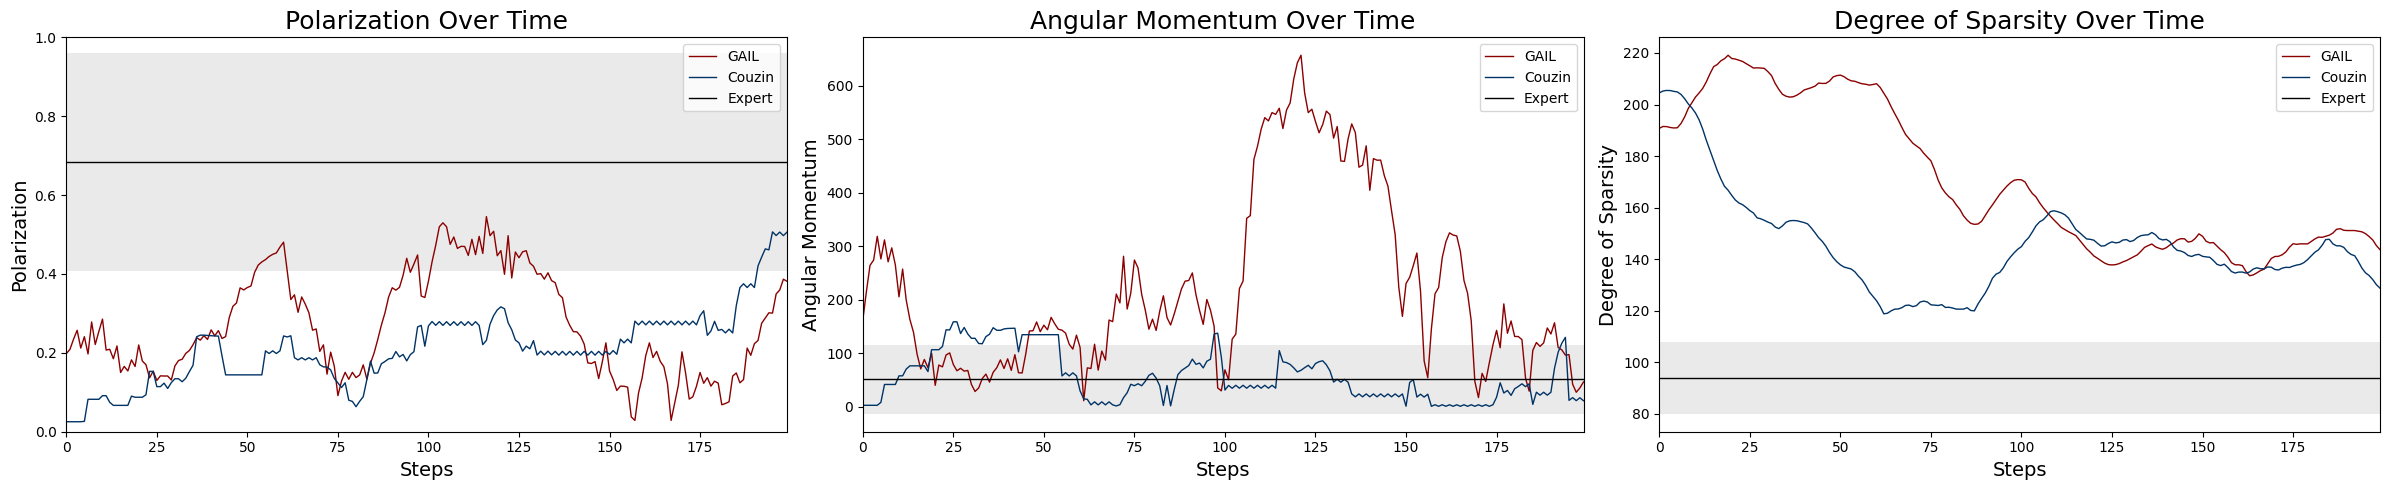

Expert Polarization: 0.6839925208836992 ± 0.27591291428204034
Expert Angular Momentum: 51.38522472715181 ± 64.14476623199725
Expert Degree of Sparsity: 93.91025135970456 ± 13.884748467064856


In [7]:
# plot swarm metrics for model comparisons
expert_values = plot_swarm_metrics(gail_metrics=gail_metrics, couzin_metrics=couzin_metrics, expert_metrics=expert_metrics)
print("Expert Polarization:", expert_values[0], "±", expert_values[1])
print("Expert Angular Momentum:", expert_values[2], "±", expert_values[3])
print("Expert Degree of Sparsity:", expert_values[4], "±", expert_values[5])

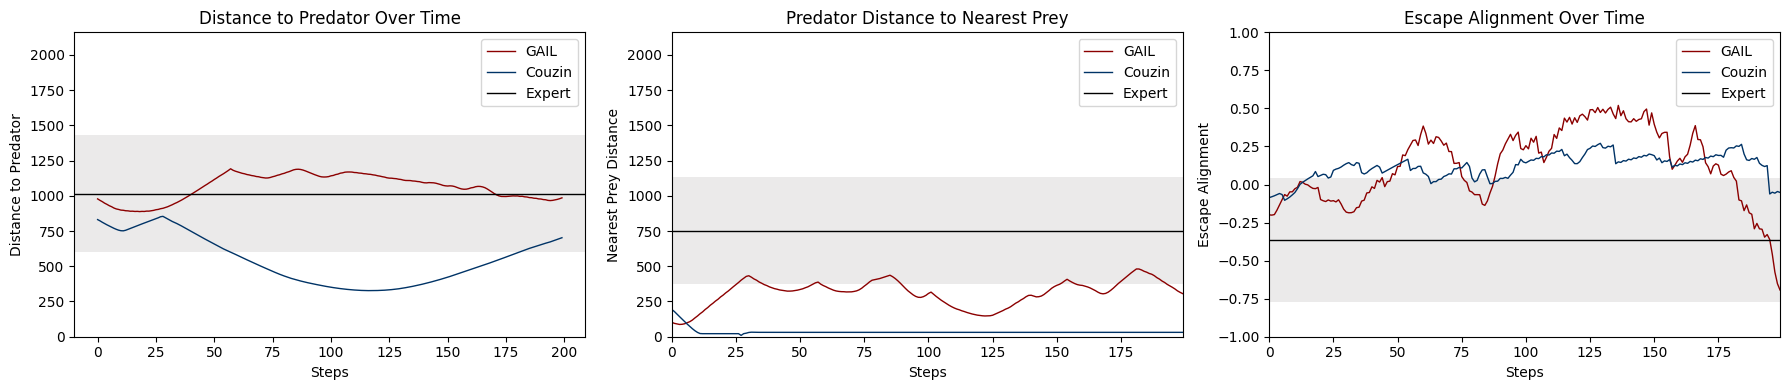

Expert Distance to Predator: 1015.34130303337 ± 416.0378085277185
Expert Nearest Prey Distance: 750.5090976632474 ± 379.63365341448383
Expert Escape Alignment: -0.3624019461261876 ± 0.40658351841850804


In [8]:
# plot pred-prey metrics for model comparisons
expert_values = plot_pred_prey_metrics(gail_metrics=gail_metrics, couzin_metrics=couzin_metrics, expert_metrics=expert_metrics)

print("Expert Distance to Predator:", expert_values[0], "±", expert_values[1])
print("Expert Nearest Prey Distance:", expert_values[2], "±", expert_values[3])
print("Expert Escape Alignment:", expert_values[4], "±", expert_values[5])

## Analysis of Modular Networks

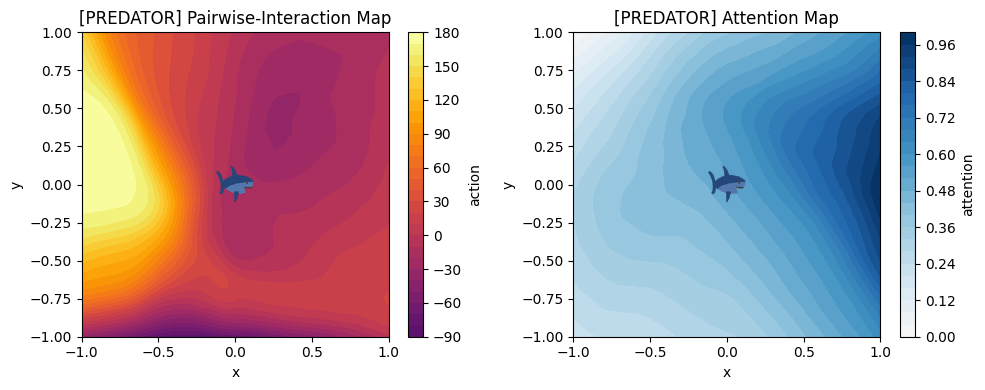

In [7]:
# load predator and prey icons
pred_img_path = rf"..\data\3. Evaluation\images\predator.png"
prey_img_path = rf"..\data\3. Evaluation\images\prey.png"

# compute and plot predator policy maps
xs, ys, pred_action_map, pred_attn_map = compute_pin_an_maps(role="predator", pin=gail_pred_policy.pairwise, an=gail_pred_policy.attention)
plot_policy_maps(xs, ys, pred_action_map, pred_attn_map, role="predator", img_path=pred_img_path)

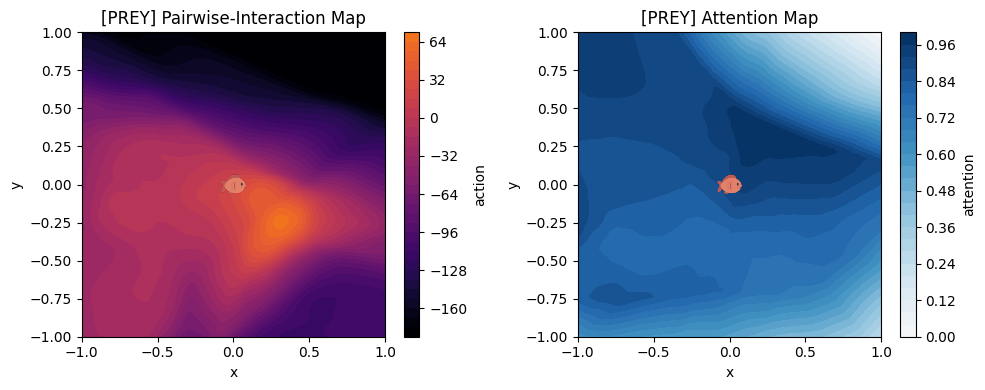

In [8]:
# compute and plot prey policy maps
xs, ys, prey_action_map, prey_attn_map = compute_pin_an_maps(role="prey", pin=gail_prey_policy.pairwise, an=gail_prey_policy.attention)
plot_policy_maps(xs, ys, prey_action_map, prey_attn_map, role="prey", img_path=prey_img_path)

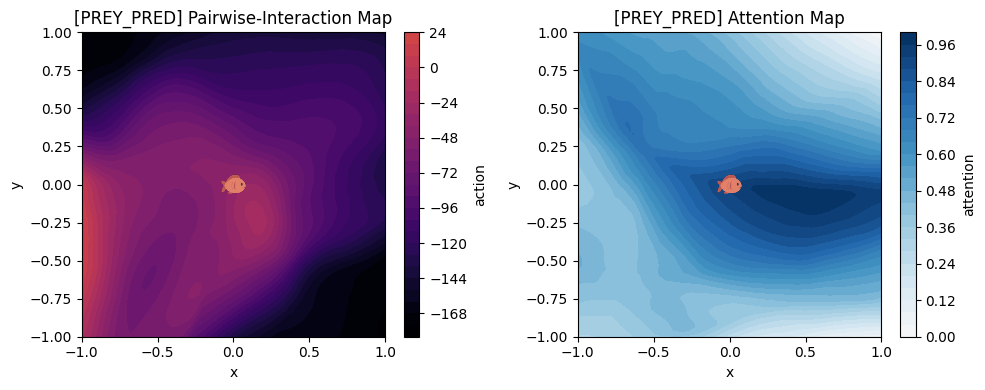

In [ ]:
# compute and plot prey-predator relationship policy maps
xs, ys, prey_action_map, prey_attn_map = compute_pin_an_maps(role="prey_pred", pin=gail_prey_policy.pairwise, an=gail_prey_policy.attention)
plot_policy_maps(xs, ys, prey_action_map, prey_attn_map, role="prey_pred", img_path=prey_img_path)

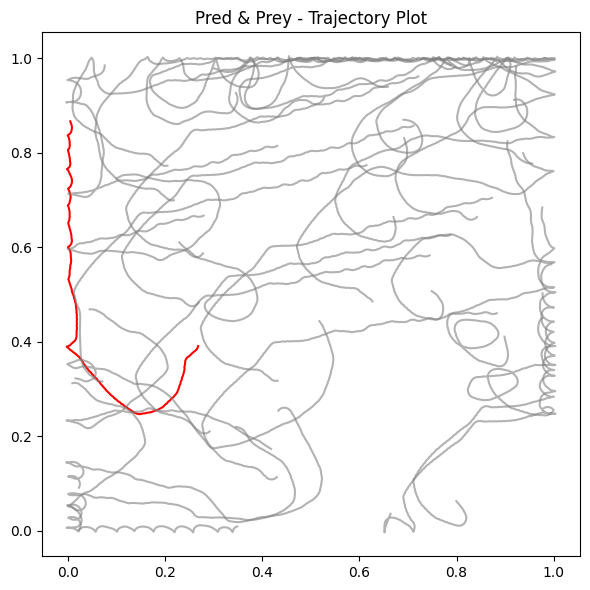

In [10]:
# plot the trajectories of agents
plot_trajectory(gail_metrics)

## Trajectory Prediction

Step 0 | Position Error: 0.0000 ± 0.0000 | Theta Error: 0.00° ± 0.00°
Step 1 | Position Error: 9.1741 ± 0.0005 | Theta Error: 14.92° ± 0.15°
Step 2 | Position Error: 17.6304 ± 0.0068 | Theta Error: 28.13° ± 1.09°
Step 3 | Position Error: 25.6891 ± 0.0534 | Theta Error: 40.41° ± 4.95°
Step 4 | Position Error: 33.4266 ± 0.1627 | Theta Error: 51.14° ± 10.67°
Step 5 | Position Error: 40.9260 ± 0.2093 | Theta Error: 62.58° ± 14.81°
Step 6 | Position Error: 48.1575 ± 0.3265 | Theta Error: 71.62° ± 19.48°
Step 7 | Position Error: 56.1581 ± 0.3535 | Theta Error: 78.08° ± 24.06°
Step 8 | Position Error: 63.7996 ± 0.6015 | Theta Error: 82.71° ± 27.42°
Step 9 | Position Error: 71.5674 ± 0.8040 | Theta Error: 87.31° ± 29.83°


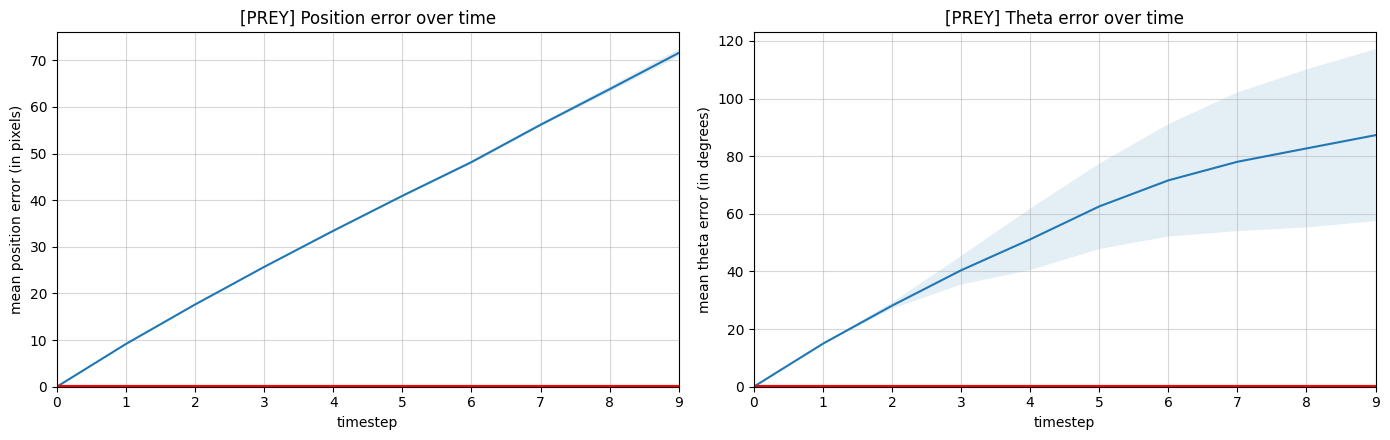

In [18]:
# compute trajectory offsets using GAIL policies
prey_positions = trajectory_offsets(gail_pred_policy, gail_prey_policy, init_pool, mc_samples=500, clip_idx=1, role="prey")

Step 0 | Position Error: 0.0000 ± 0.0000 | Theta Error: 0.00° ± 0.00°
Step 1 | Position Error: 8.5368 ± 0.0232 | Theta Error: 3.70° ± 3.15°
Step 2 | Position Error: 17.1490 ± 0.1011 | Theta Error: 16.03° ± 8.79°
Step 3 | Position Error: 26.0300 ± 0.1584 | Theta Error: 31.65° ± 11.12°
Step 4 | Position Error: 33.6087 ± 0.3400 | Theta Error: 48.41° ± 12.56°
Step 5 | Position Error: 37.8968 ± 1.3586 | Theta Error: 60.02° ± 11.42°
Step 6 | Position Error: 44.6024 ± 2.6221 | Theta Error: 68.71° ± 12.80°
Step 7 | Position Error: 52.9816 ± 3.8686 | Theta Error: 77.44° ± 16.12°
Step 8 | Position Error: 61.0695 ± 4.9021 | Theta Error: 83.23° ± 21.49°
Step 9 | Position Error: 69.0401 ± 6.2269 | Theta Error: 90.69° ± 27.12°


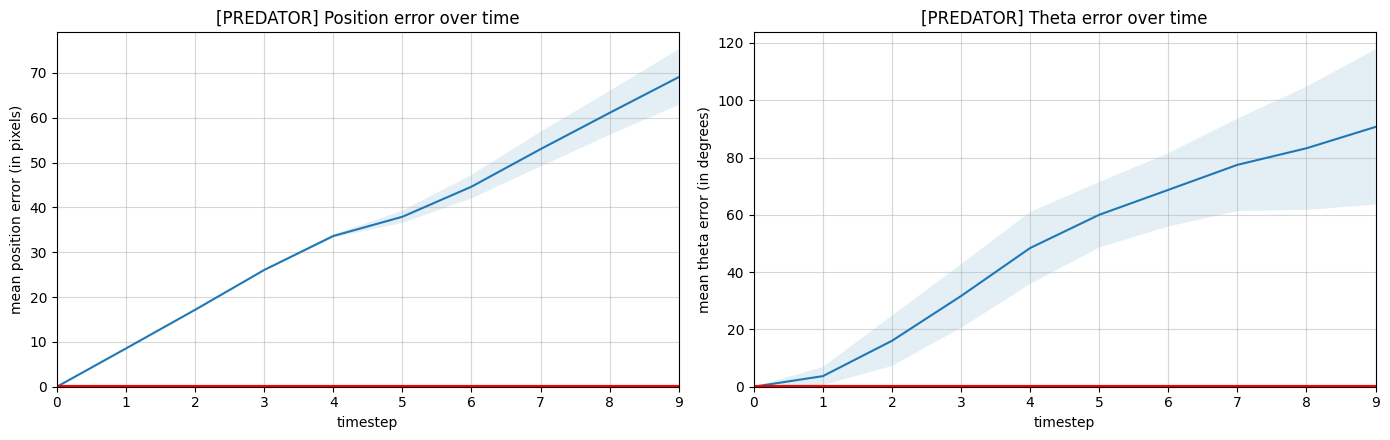

In [19]:
# compute trajectory offsets using GAIL policies
pred_positions = trajectory_offsets(gail_pred_policy, gail_prey_policy, init_pool, mc_samples=500, clip_idx=1, role="predator")

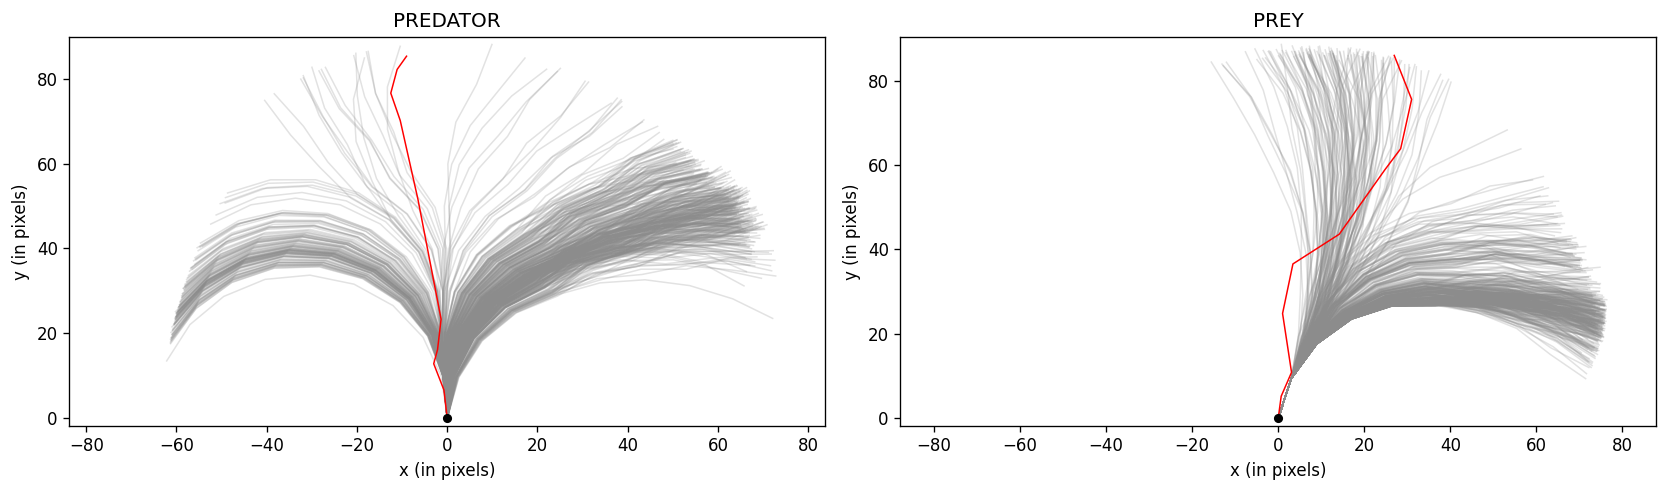

In [21]:
# plot simulation trajectories of GAIL policies and expert trajectory for comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 4.2), dpi=120)  # wider figure
trajectory_plot(axes[0], agent_idx=0, role="Predator", positions=pred_positions, scale=4.5) 
trajectory_plot(axes[1], agent_idx=21, role="Prey", positions=prey_positions, scale=9) 

plt.tight_layout()
plt.show()

## Social Role Analysis

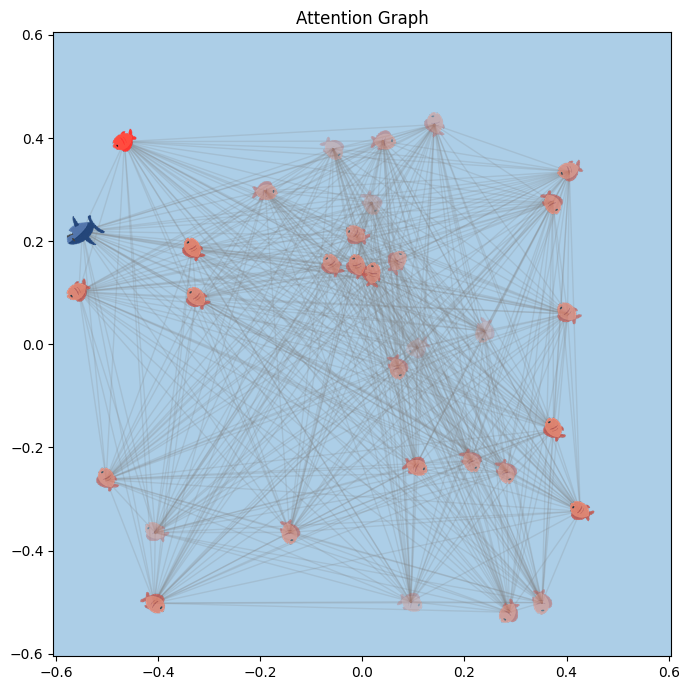

In [ ]:
# load predator and prey icons
pred_img_path = rf"..\data\3. Evaluation\images\predator.png"
prey_img_path = rf"..\data\3. Evaluation\images\prey.png"

# plot attention graph for a specific frame
draw_attention_graph(gail_metrics, frame_idx=1, pred_img_path=pred_img_path, prey_img_path=prey_img_path)

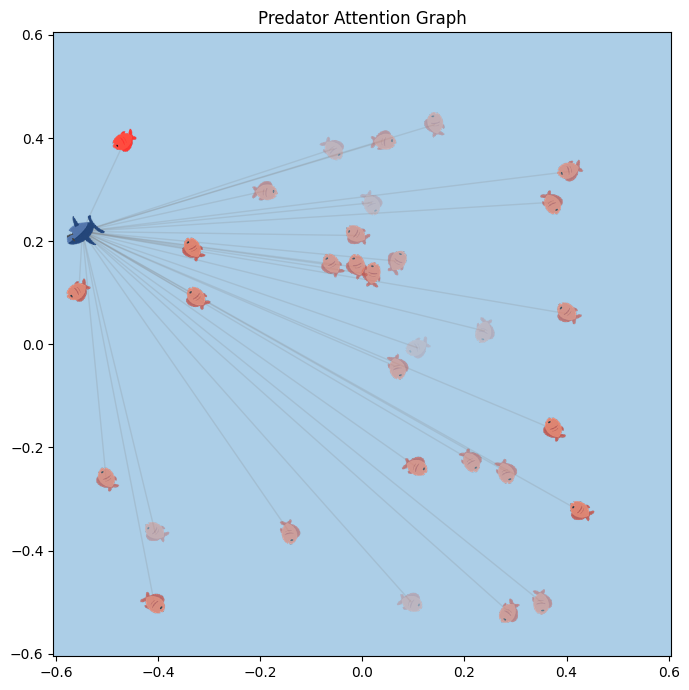

In [16]:
# plot predator attention graph for a specific frame
draw_predator_attention_graph(gail_metrics, frame_idx=1, pred_img_path=pred_img_path, prey_img_path=prey_img_path)

In [17]:
# create attention graph video
attn_graph_dir = rf"..\results\experiment garcia\attention graph frames"
record_attn_graph_video(gail_metrics, num_steps=200, pred_img_path=pred_img_path, prey_img_path=prey_img_path, save_dir=attn_graph_dir)

Saved frame 0/200
Saved frame 25/200
Saved frame 50/200
Saved frame 75/200
Saved frame 100/200
Saved frame 125/200
Saved frame 150/200
Saved frame 175/200
Video rendered!
